# Assignment 3, Datascience, 2022 2nd Semester, Konkuk University
* Writer: WONJUN PARK, 201811182

## 문제 정의
* 엑셀파일의 db_score 데이터에 대하여 label attribute를 grade로 정의한다. feature variable은 homework, discussion, midterm 3가지 애트리뷰트 만으로 구성하기로 한다. 다음 각각에 대하여 과제를 수행하시오.

1. db_score 엑셀 파일을 읽어들여 DB 테이블로 구축하되, homework, discussion, midterm, grade 만 포함하는 테이블을 구성하라.(20점)
    - 단, grade는 A 학점은 그대로 A학점, B와 C 학점은 B학점으로 변환하고, D와 F 학점은 C학점으로 변환하여 DB에 입력하기로 한다.
    
2. classification 알고리즘 중에서 SVM, Logistic Regression 두가지 알고리즘에 대하여 공부하고 알고리즘에 대한 원리 등을 요약해서 작성하고, scikit-learn 라이브러리에서 각각의 함수를 어떻게 사용하는지 설명하라.(20점)

3. grade B에 대한 2가지 알고리즘들의 binary classification 성능결과를 얻을 수 있는 python 프로그램을 작성하고 결과를 제시/분석하라.(30점)
    1. train_test_split() 를 활용하여, 2:1로 데이터를 나누었을때의 성능
    2. K-fold cross validation 방법으로 데이터를 5 그룹으로 나누어서 실행했을 때의 성능
    
    - 성능은 accuracy 등 4가지 measure 사용할 것

4. grade A, B, C 에 대한 2가지 알고리즘들의 multi-class classification 성능결과를 얻을 수 있는 python 프로그램을 작성하고 결과를 제시/분석하라.(30점)
    1. train_test_split() 를 활용하여, 2:1로 데이터를 나누었을때의 성능
    2. K-fold cross validation 방법으로 데이터를 5 그룹으로 나누어서 실행했을 때의 성능
    
    - 성능은 accuracy 등 4가지 measure 사용할 것

In [30]:
from db_conn import *
import pandas as pd

def problem_one(df):
    ### change grade value C -> B, D and F -> C
    grade = df['grade']
    grade = [x if x == 'A' else ('B' if x == 'B' or x == 'C' else 'C') for x in grade]
    grade = pd.DataFrame(grade, columns = ['grade'])
        
    ### make table
    table = df.loc[:, ['homework', 'discussion', 'midterm']]
    table = pd.concat([table, grade], axis=1)
    
    ### connect to database
    conn, cur = open_db()
    
    sql = """
        drop table if exists score;
    
        create table score(
                    homework	decimal(4,2),
                    discussion	int,
                    midterm		decimal(4,2),
                    grade 		char(1)
                );
    """
    cur.execute(sql)
    
    rows = []
    for t in table.values:
        rows.append(tuple(t))

    insert_sql = """
        insert into score(homework, discussion, midterm, grade)
            values(%s, %s, %s, %s);
    """

    cur.executemany(insert_sql, rows)
    conn.commit()
    
    close_db(conn, cur)

In [36]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn import svm
from sklearn.linear_model import LogisticRegression
import numpy as np

def load_data():
    conn, cur = open_db()
    
    sql = """select * from score;"""    
    cur.execute(sql)
    data = cur.fetchall()
    
    close_db(conn, cur)
    
    return data

def binary_classification_preprocess_data(data):
    X = [(t['homework'], t['discussion'], t['midterm']) for t in data]
    X = np.array(X)
    
    """ grade 'B'이면 positive(1), 나머지 성적 'A', 'C'는 Negative(-1) """
    y = [1 if t['grade'] == 'B' else -1 for t in data]
    y = np.array(y)
    
    return X, y

def binary_classification_with_SVM(X_train, y_train, X_test):
    clf = svm.SVC()
    clf.fit(X_train, y_train)
    y_predict = clf.predict(X_test)
    
    return y_predict

def binary_classification_with_LogisticRegression(X_train, y_train, X_test):
    clf = LogisticRegression(random_state=0).fit(X_train, y_train)
    y_predict = clf.predict(X_test)
    
    return y_predict

def binary_classification_model_evaluation(y_test, y_predict):
    tp, tn, fp, fn = 0, 0, 0, 0

    for y, yp in zip(y_test, y_predict):
        if y == 1 and yp == 1:
            tp += 1
        elif y == 1 and yp == -1:
            fn += 1
        elif y == -1 and yp == 1:
            fp += 1
        else: # y == -1 and yp == -1
            tn += 1

    try:
        accuracy = (tp + tn) / (tp + tn + fp + fn)
    except ZeroDivisionError:
        print('Zero Division Error in accuracy')
        accuracy = 0
    try:
        precision = (tp) / (tp + fp)
    except ZeroDivisionError:
        print('Zero Division Error in precision')
        precision = 0
    try:
        recall = (tp) / (tp + fn)
    except ZeroDivisionError:
        print('Zero Division Error in recall')
        recall = 0
    try:
        f1_score = 2 * precision * recall / (precision + recall)
    except ZeroDivisionError:
        print('Zero Division Error in f1_score')
        f1_score = 0

    return accuracy, precision, recall, f1_score

def binary_classification_train_test_split(X, y):
    print('### train_test_split')
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
    
    y_predict = binary_classification_with_SVM(X_train, y_train, X_test)
    acc, prec, recall, f1 = binary_classification_model_evaluation(y_test, y_predict)
    print('[SVM] accuracy: %.3f, precision: %.3f, recall: %.3f, f1: %.3f' % (acc, prec, recall, f1))
    
    y_predict = binary_classification_with_LogisticRegression(X_train, y_train, X_test)
    acc, prec, recall, f1 = binary_classification_model_evaluation(y_test, y_predict)
    print('[Logistic Regression] accuracy: %.3f, precision: %.3f, recall: %.3f, f1: %.3f' % (acc, prec, recall, f1))

def binary_classification_k_fold(X, y):
    print('### K-Fold')
    svm_score = {'acc': np.array([]), 'prec': np.array([]), 'recall': np.array([]), 'f1': np.array([]), }
    lr_score = {'acc': np.array([]), 'prec': np.array([]), 'recall': np.array([]), 'f1': np.array([]), }
    
    kf = KFold(n_splits=5, random_state=42, shuffle=True)
    for train_index, test_index in kf.split(X):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        
        y_predict = binary_classification_with_SVM(X_train, y_train, X_test)
        score = binary_classification_model_evaluation(y_test, y_predict)
        
        svm_score['acc'] = np.append(svm_score['acc'], score[0])
        svm_score['prec'] = np.append(svm_score['prec'], score[1])
        svm_score['recall'] = np.append(svm_score['recall'], score[2])
        svm_score['f1'] = np.append(svm_score['f1'], score[3])
        
        y_predict = binary_classification_with_LogisticRegression(X_train, y_train, X_test)
        score = binary_classification_model_evaluation(y_test, y_predict)
        svm_score['acc'] = np.append(svm_score['acc'], score[0])
        svm_score['prec'] = np.append(svm_score['prec'], score[1])
        svm_score['recall'] = np.append(svm_score['recall'], score[2])
        svm_score['f1'] = np.append(svm_score['f1'], score[3])
    
    print('[SVM] accuracy: %.3f, precision: %.3f, recall: %.3f, f1: %.3f' 
          % (svm_score['acc'].mean(), svm_score['prec'].mean(), svm_score['recall'].mean(), svm_score['f1'].mean()))
    
    print('[Logistic Regression]  accuracy: %.3f, precision: %.3f, recall: %.3f, f1: %.3f' 
          % (svm_score['acc'].mean(), svm_score['prec'].mean(), svm_score['recall'].mean(), svm_score['f1'].mean()))

def problem_three():
    print('# Binary Classification')
    data = load_data()
    X, y = binary_classification_preprocess_data(data)
    
    binary_classification_train_test_split(X, y)
    binary_classification_k_fold(X, y)

In [38]:
def multiclass_preprocess_data(data):
    X = [(t['homework'], t['discussion'], t['midterm']) for t in data]
    X = np.array(X)
    
    y = [t['grade'] for t in data]
    y = np.array(y)
    
    return X, y

def multiclass_classification_model_evaluation(y_test, y_predict):
    A, B, C = 0, 1, 2
    table = np.zeros((3, 3), dtype=object)
    
    for y, yp in zip(y_test, y_predict):
        if y == 'A' and yp == 'A':
            table[A][A] += 1
        elif y == 'A' and yp == 'B':
            table[A][B] += 1
        elif y == 'A' and yp == 'C':
            table[A][C] += 1
            
        elif y == 'B' and yp == 'A':
            table[B][A] += 1
        elif y == 'B' and yp == 'B':
            table[B][B] += 1
        elif y == 'B' and yp == 'C':
            table[B][C] += 1
            
        elif y == 'C' and yp == 'A':
            table[C][A] += 1
        elif y == 'C' and yp == 'B':
            table[C][B] += 1
        elif y == 'C' and yp == 'C':
            table[C][C] += 1
            
    try:
        accuracy = (table[A][A] + table[B][B] + table[C][C]) / len(y_predict)
    except ZeroDivisionError:
        print('Zero Division Error in accuracy')
        accuracy = 0
    
    try:
        precision_A = table[A][A] / (table[A][A] + table[B][A] + table[C][A])
    except ZeroDivisionError:
        print('Zero Division Error in precision A')
        precision_A = 0
    try:
        precision_B = table[B][B] / (table[A][B] + table[B][B] + table[C][B])
    except ZeroDivisionError:
        print('Zero Division Error in precision B')
        precision_B = 0
    try:
        precision_C = table[C][C] / (table[A][C] + table[B][C] + table[C][C])
    except ZeroDivisionError:
        print('Zero Division Error in precision C')
        precision_C = 0
    
    try:
        recall_A = table[A][A] / (table[A][A] + table[A][B] + table[A][C])
    except ZeroDivisionError:
        print('Zero Division Error in recall A')
        recall_A = 0
    try:
        recall_B = table[B][B] / (table[B][A] + table[B][B] + table[B][C])
    except ZeroDivisionError:
        print('Zero Division Error in recall B')
        recall_B = 0
    try:
        recall_C = table[C][C] / (table[C][A] + table[C][B] + table[C][C])
    except ZeroDivisionError:
        print('Zero Division Error in recall C')
        recall_C = 0
    
    try:
        f1_A = (2 * precision_A * recall_A) / (precision_A + recall_A)
    except ZeroDivisionError:
        print('Zero Division Error in f1 A')
        f1_A = 0
    try:
        f1_B = (2 * precision_B * recall_B) / (precision_B + recall_B)
    except ZeroDivisionError:
        print('Zero Division Error in f1 B')
        f1_B = 0
    try:
        f1_C = (2 * precision_C * recall_C) / (precision_C + recall_C)
    except ZeroDivisionError:
        print('Zero Division Error in f1 C')
        f1_C = 0
    
    precision = np.array([precision_A, precision_B, precision_C])
    recall = np.array([recall_A, recall_B, recall_C])
    f1_score = np.array([f1_A, f1_B, f1_C])

    return accuracy, precision, recall, f1_score

def multiclass_classification_with_SVM(X_train, y_train, X_test):
    clf = svm.SVC(decision_function_shape='ovo')
    clf.fit(X_train, y_train)
    y_predict = clf.predict(X_test)
    return y_predict

def multiclass_classification_with_LogisticRegression(X_train, y_train, X_test):
    clf = LogisticRegression(random_state=0).fit(X_train, y_train)
    y_predict = clf.predict(X_test)
    return y_predict

def multiclass_classification_train_test_split(X, y):
    print('### train_test_split')
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
    
    LABEL = ('A', 'B', 'C')
    y_predict = multiclass_classification_with_SVM(X_train, y_train, X_test)
    acc, prec, rec, f1 = multiclass_classification_model_evaluation(y_test, y_predict)
    for label, precision, recall, f1_score in zip(LABEL, prec, rec, f1):
        print('[SVM] positive: %s, accuracy: %.3f, precision: %.3f, recall: %.3f, f1: %.3f'
              % (label, acc, precision, recall, f1_score))
    
    y_predict = multiclass_classification_with_LogisticRegression(X_train, y_train, X_test)
    acc, prec, rec, f1 = multiclass_classification_model_evaluation(y_test, y_predict)
    for label, precision, recall, f1_score in zip(LABEL, prec, rec, f1):
        print('[Logistic Regression] positive: %s, accuracy: %.3f, precision: %.3f, recall: %.3f, f1: %.3f'
              % (label, acc, precision, recall, f1_score))
    
def multiclass_classification_k_fold(X, y):
    print('### K-Fold')
    svm_scores, lr_scores = np.empty((0,4)), np.empty((0,4))
    
    kf = KFold(n_splits=5, random_state=42, shuffle=True)
    for train_index, test_index in kf.split(X):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        
        y_predict = multiclass_classification_with_SVM(X_train, y_train, X_test)
        score = multiclass_classification_model_evaluation(y_test, y_predict)
        svm_scores = np.append(svm_scores, [score], axis=0)
        
        y_predict = multiclass_classification_with_LogisticRegression(X_train, y_train, X_test)
        score = multiclass_classification_model_evaluation(y_test, y_predict)
        lr_scores = np.append(lr_scores, [score], axis=0)
    
    svm_acc = np.empty(0)
    svm_prec_A, svm_prec_B, svm_prec_C = np.empty(0), np.empty(0), np.empty(0)
    svm_rec_A, svm_rec_B, svm_rec_C = np.empty(0), np.empty(0), np.empty(0)
    svm_f1_A, svm_f1_B, svm_f1_C = np.empty(0), np.empty(0), np.empty(0)
    
    lr_acc = np.empty(0)
    lr_prec_A, lr_prec_B, lr_prec_C = np.empty(0), np.empty(0), np.empty(0)
    lr_rec_A, lr_rec_B, lr_rec_C = np.empty(0), np.empty(0), np.empty(0)
    lr_f1_A, lr_f1_B, lr_f1_C = np.empty(0), np.empty(0), np.empty(0)
    
    for svm_score, lr_score in zip(svm_scores, lr_scores):
        svm_acc = np.append(svm_acc, svm_score[0])
        lr_acc = np.append(lr_acc, lr_score[0])
        
        svm_prec_A = np.append(svm_prec_A, svm_score[1][0])
        svm_prec_B = np.append(svm_prec_B, svm_score[1][1])
        svm_prec_C = np.append(svm_prec_C, svm_score[1][2])
        lr_prec_A = np.append(lr_prec_A, lr_score[1][0])
        lr_prec_B = np.append(lr_prec_B, lr_score[1][1])
        lr_prec_C = np.append(lr_prec_C, lr_score[1][2])
        
        svm_rec_A = np.append(svm_rec_A, svm_score[2][0])
        svm_rec_B = np.append(svm_rec_B, svm_score[2][1])
        svm_rec_C = np.append(svm_rec_C, svm_score[2][2])
        lr_rec_A = np.append(lr_rec_A, lr_score[2][0])
        lr_rec_B = np.append(lr_rec_B, lr_score[2][1])
        lr_rec_C = np.append(lr_rec_C, lr_score[2][2])
        
        svm_f1_A = np.append(svm_f1_A, svm_score[3][0])
        svm_f1_B = np.append(svm_f1_B, svm_score[3][1])
        svm_f1_C = np.append(svm_f1_C, svm_score[3][2])
        lr_f1_A = np.append(lr_f1_A, lr_score[3][0])
        lr_f1_B = np.append(lr_f1_B, lr_score[3][1])
        lr_f1_C = np.append(lr_f1_C, lr_score[3][2])
    
    svm_acc = svm_acc.mean()
    lr_acc = lr_acc.mean()
    
    svm_prec_A, svm_prec_B, svm_prec_C = svm_prec_A.mean(), svm_prec_B.mean(), svm_prec_C.mean()
    svm_prec = np.array([svm_prec_A, svm_prec_B, svm_prec_C])
    lr_prec_A, lr_prec_B, lr_prec_C = lr_prec_A.mean(), lr_prec_B.mean(), lr_prec_C.mean()
    lr_prec = np.array([lr_prec_A, lr_prec_B, lr_prec_C])
    
    svm_rec_A, svm_rec_B, svm_rec_C = svm_rec_A.mean(), svm_rec_B.mean(), svm_rec_C.mean()
    svm_rec = np.array([svm_rec_A, svm_rec_B, svm_rec_C])
    lr_rec_A, lr_rec_B, lr_rec_C = lr_rec_A.mean(), lr_rec_B.mean(), lr_rec_C.mean()
    lr_rec = np.array([lr_rec_A, lr_rec_B, lr_rec_C])
    
    svm_f1_A, svm_f1_B, svm_f1_C = svm_f1_A.mean(), svm_f1_B.mean(), svm_f1_C.mean()
    svm_f1 = np.array([svm_f1_A, svm_f1_B, svm_f1_C])
    lr_f1_A, lr_f1_B, lr_f1_C = lr_f1_A.mean(), lr_f1_B.mean(), lr_f1_C.mean()
    lr_f1 = np.array([lr_f1_A, lr_f1_B, lr_f1_C])
    
    LABEL = ('A', 'B', 'C')
    for label, precision, recall, f1_score in zip(LABEL, svm_prec, svm_rec, svm_f1):
        print('[SVM] positive: %s, accuracy: %.3f, precision: %.3f, recall: %.3f, f1: %.3f'
              % (label, svm_acc, precision, recall, f1_score))
    for label, precision, recall, f1_score in zip(LABEL, lr_prec, lr_rec, lr_f1):
        print('[Logistic Regression] positive: %s, accuracy: %.3f, precision: %.3f, recall: %.3f, f1: %.3f' 
              % (label, lr_acc, precision, recall, f1_score))

def problem_four():
    print('# Multi-Class Classification')
    data = load_data()
    X, y = multiclass_preprocess_data(data)
    
    multiclass_classification_train_test_split(X, y)
    multiclass_classification_k_fold(X, y)

In [26]:
if __name__ == '__main__':
    excel_file = 'db_score.xlsx'
    df = pd.read_excel(excel_file)

    problem_one(df)
    
    problem_three()
    problem_four()

# Binary Classification
### train_test_split
[SVM] accuracy: 0.581, precision: 0.478, recall: 0.917, f1: 0.629
[Logistic Regression] accuracy: 0.613, precision: 0.500, recall: 0.500, f1: 0.500
### K-Fold
Zero Division Error in precision
Zero Division Error in f1_score
[SVM] accuracy: 0.559, precision: 0.455, recall: 0.624, f1: 0.502
[Logistic Regression]  accuracy: 0.559, precision: 0.455, recall: 0.624, f1: 0.502
# Multi-Class Classification
### train_test_split
Zero Division Error in precision A
Zero Division Error in f1 A
[SVM] positive: A, accuracy: 0.581, precision: 0.000, recall: 0.000, f1: 0.000
[SVM] positive: B, accuracy: 0.581, precision: 0.478, recall: 0.917, f1: 0.629
[SVM] positive: C, accuracy: 0.581, precision: 0.875, recall: 0.636, f1: 0.737
[Logistic Regression] positive: A, accuracy: 0.613, precision: 0.500, recall: 0.375, f1: 0.429
[Logistic Regression] positive: B, accuracy: 0.613, precision: 0.500, recall: 0.583, f1: 0.538
[Logistic Regression] positive: C, accurac

<__array_function__ internals>:180: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
<__array_function__ internals>:180: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different leng

### Research
* Analyze features with 2-D Diagram, 3-D Diagram
    - [Binary 3-D Diagram](./mpl3d_scatter_binary.gif)
    - [Multiclass 3-D Diagram](./mpl3d_scatter_multiclass.gif)
        - [Reference about drawing 3D scatter plot](https://matplotlib.org/stable/gallery/mplot3d/scatter3d.html)

* Count the number of grade what it contains
    - Binary data
    - Multiclass data

/usr/local/lib/python3.8/dist-packages/seaborn/axisgrid.py:745: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  plot_args = [v for k, v in plot_data.iteritems()]
/usr/local/lib/python3.8/dist-packages/seaborn/axisgrid.py:745: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  plot_args = [v for k, v in plot_data.iteritems()]
/usr/local/lib/python3.8/dist-packages/seaborn/axisgrid.py:745: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  plot_args = [v for k, v in plot_data.iteritems()]
/usr/local/lib/python3.8/dist-packages/seaborn/axisgrid.py:745: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  plot_args = [v for k, v in plot_data.iteritems()]
/usr/local/lib/python3.8/dist-packages/seaborn/axisgrid.py:745: FutureWarning: iteritems is deprecated and will be removed in a future v

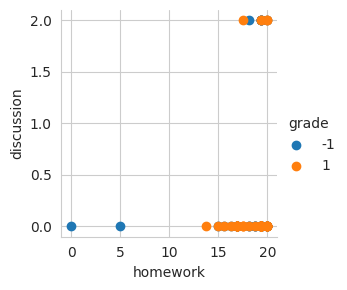

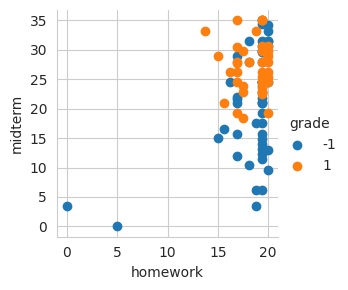

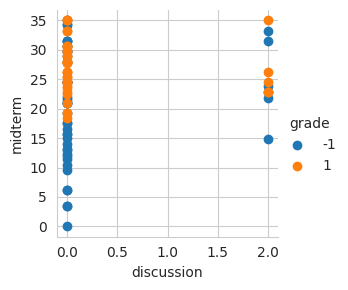

In [6]:
import seaborn as sns
import matplotlib.pyplot as plt

data = load_data()
data = pd.DataFrame(data)

grade = data['grade']
grade = [1 if t == 'B' else -1 for t in grade]
grade = pd.DataFrame(grade, columns = ['grade'])

data = data.loc[:, ['homework', 'discussion', 'midterm']]
data = pd.concat([data, grade], axis=1)

sns.set_style('whitegrid')
sns.FacetGrid(data, hue='grade').map(plt.scatter, 'homework', 'discussion').add_legend()
sns.FacetGrid(data, hue='grade').map(plt.scatter, 'homework', 'midterm').add_legend()
sns.FacetGrid(data, hue='grade').map(plt.scatter, 'discussion', 'midterm').add_legend()
plt.show()

MovieWriter ffmpeg unavailable; using Pillow instead.


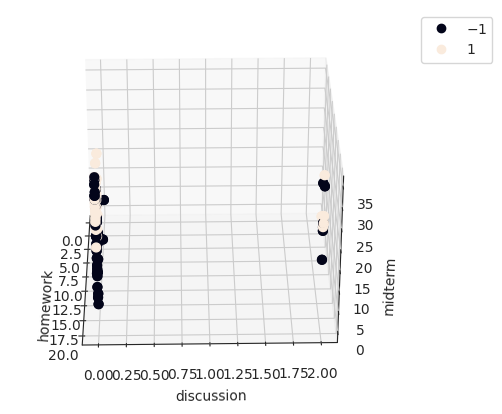

In [278]:
import re, seaborn as sns
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.colors import ListedColormap
from matplotlib import animation

fig, ax = plt.subplots(figsize=(10, 5), subplot_kw={"projection":"3d"})

cmap = ListedColormap(sns.color_palette("husl", 256).as_hex())

def animate(i):
    ax.view_init(elev=30., azim=i)
    
    return fig,

def init():
    sns.set_style('ticks')
    
    sc = ax.scatter(x, y, z, s=40, c=data['grade'], marker='o', alpha=1)
    
    ax.set_xlabel('homework')
    ax.set_ylabel('discussion')
    ax.set_zlabel('midterm')
    
    
    plt.legend(*sc.legend_elements(), bbox_to_anchor=(1.05, 1), loc=2)
    
    return fig,    
    
excel_file = 'db_score.xlsx'
data = pd.read_excel(excel_file)

grade = df['grade']
grade = [x if x == 'A' else ('B' if x == 'B' or x == 'C' else 'C') for x in grade]
grade = [1 if t == 'B' else -1 for t in grade]
grade = pd.DataFrame(grade, columns = ['grade'])

data = data.loc[:, ['homework', 'discussion', 'midterm']]
data = pd.concat([data, grade], axis=1)

x, y, z = data['homework'], data['discussion'], data['midterm']

anim = animation.FuncAnimation(fig, animate, init_func=init,
                               frames=360, interval=20, blit=True)
anim.save('mpl3d_scatter_binary.gif', fps=30)

plt.show()

MovieWriter ffmpeg unavailable; using Pillow instead.


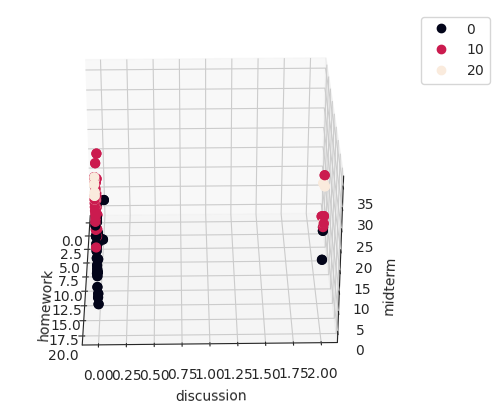

In [280]:
import re, seaborn as sns
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.colors import ListedColormap
from matplotlib import animation

fig, ax = plt.subplots(figsize=(10, 5), subplot_kw={"projection":"3d"})

cmap = ListedColormap(sns.color_palette("husl", 256).as_hex())

def animate(i):
    ax.view_init(elev=30., azim=i)
    
    return fig,

def init():
    sns.set_style('ticks')
    
    sc = ax.scatter(x, y, z, s=40, c=data['grade'], marker='o', alpha=1)
    
    ax.set_xlabel('homework')
    ax.set_ylabel('discussion')
    ax.set_zlabel('midterm')
    
    
    plt.legend(*sc.legend_elements(), bbox_to_anchor=(1.05, 1), loc=2)
    
    return fig,    
    
excel_file = 'db_score.xlsx'
data = pd.read_excel(excel_file)

grade = df['grade']
grade = [x if x == 'A' else ('B' if x == 'B' or x == 'C' else 'C') for x in grade]
grade = [10 if t == 'B' else (20 if t == 'A' else 0) for t in grade]
grade = pd.DataFrame(grade, columns = ['grade'])

data = data.loc[:, ['homework', 'discussion', 'midterm']]
data = pd.concat([data, grade], axis=1)

x, y, z = data['homework'], data['discussion'], data['midterm']

anim = animation.FuncAnimation(fig, animate, init_func=init,
                               frames=360, interval=20, blit=True)
anim.save('mpl3d_scatter_multiclass.gif', fps=30)

plt.show()

In [40]:
excel_file = 'db_score.xlsx'
data = pd.read_excel(excel_file)

grade = df['grade']
grade = [x if x == 'A' else ('B' if x == 'B' or x == 'C' else 'C') for x in grade]
grade = [1 if t == 'B' else -1 for t in grade]

count = [0, 0]
for i in grade:
    if i == 1:
        count[0] += 1
    elif i == -1:
        count[1] += 1
print(count)

[40, 52]


In [281]:
excel_file = 'db_score.xlsx'
data = pd.read_excel(excel_file)

grade = df['grade']
grade = [x if x == 'A' else ('B' if x == 'B' or x == 'C' else 'C') for x in grade]
grade = [10 if t == 'B' else (20 if t == 'A' else 0) for t in grade]

count = [0, 0, 0]
for i in grade:
    if i == 20:
        count[0] += 1
    elif i == 10:
        count[1] += 1
    else:
        count[2] += 1
print(count)

[20, 40, 32]
